In [1]:
%load_ext autoreload
%autoreload 2
directory = '/scratch/6256481/'
projection       = 'EPSG:3857'
projection_coord = 'EPSG:4326'
import sys
sys.path.insert(0, directory + f'python/py_code/')

import geopandas as gpd
import pandas as pd
import ast
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import LineString, Point, MultiPoint, MultiLineString, Polygon
from shapely import box as Box
import netCDF4
import numpy as np
from get_orthogonals import get_orthogonals
from dem import find_dem_FAB
from tqdm import tqdm
from support import get_ids, node_position
import glob
from osgeo import gdal
from skimage import measure


from extract_slope_along_raster_line import extract_slope_along_raster_line
from line_functions import getExtrapoledLine
from datetime import datetime as dt
from inflection_points import inflection_points,inflection_points_curve
from smoothing import SG_smoothing
from connect_geometries import merge_centerlines
import scipy as sc
from run_confinement_values import confinement_factor
from dem import get_raster_vrt
from calc_functions import confinement_values
from datetime import datetime as dt
from scipy.spatial import cKDTree

# Add a colorbar with the proper adjustments
from mpl_toolkits.axes_grid1 import make_axes_locatable

from confinement_margin import confinement_margin

from calc_functions import x_y_intercept

from confinement_margin import get_raster_side
from run_confinement_values import calc_confinement_values
from get_orthogonals import get_orthogonals
from dem import find_dem

from support import create_dir, create_custom_cmap, adjust_new_segments
from line_functions import split_ring
from dem import find_dem_bounds_FAB

import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
findGrouopFiles = glob.glob(directory + 'results/all/*eu*50*')
for f in tqdm(findGrouopFiles):
    D     = pd.read_csv(f)
    if 21602600701 in D['reach_id'].values:
        print(f)
        break

 50%|█████     | 3/6 [01:02<01:02, 20.76s/it]

/scratch/6256481/results/all/eu_00_50.csv


In [2]:
c = 'eu'
i = '00'

create_new = False
vector_save_file = directory +f'results/new_segments/vector/{c}_{i}_reach_new_segments.gpkg'
node_save_file   = directory +f'results/new_segments/node/{c}_{i}_node_new_segments.gpkg' 

In [3]:
df     = gpd.read_file(vector_save_file)
dfNode = gpd.read_file(node_save_file)

df   = adjust_new_segments(df)
dfCF = pd.read_csv(directory + 'results/confinement_factor.csv')

# Orthogonal testing

In [12]:
df[df['reach_id'] == 21602600681].river_name

1956    Rhone
Name: river_name, dtype: object

In [10]:

T = 21602600701
T = 21602600681
int(df.loc[df.reach_id == T, 'combined_reach_id'].iloc[0])

995

In [4]:
minLenFactor = 4*12
dfSF = pd.read_csv(directory + 'results/smoothingFactor.csv')
DEMprojection = 'EPSG:4326'
dfDemBounds = find_dem_bounds_FAB(directory, DEMprojection)

ids = df.loc[df['include_flag'] == '0', 'combined_reach_id'].unique()
# ids = [7005, 8260]
# ids = [8527, 9332]
# ids = [ids[515]]
ids = [2487]
ids = [995]

vrt_file = directory + "input_created/FAB_dem_vrt.vrt"
demVRT   = gdal.Open(vrt_file)
for id in tqdm(ids):
    dt1 = dt.now()
    dfReach      = df[df['combined_reach_id'] == id].copy()
    dfReachNodes = dfNode[dfNode['reach_id'].isin(dfReach['reach_id'].values)].copy()

    GroupedCRS = dfReach.groupby('localCRS', as_index = False).size()
    reachCRS   = GroupedCRS.loc[GroupedCRS['size'] == GroupedCRS['size'].max()
                                ,'localCRS'].iloc[0]
    
    dfReach      = dfReach.to_crs(reachCRS)
    dfReachNodes = dfReachNodes.to_crs(reachCRS)

    combinedLine, _, _ = merge_centerlines(dfReach, df, reachCRS)
    dfReachNodes = node_position(combinedLine, dfReachNodes)
    
    maxWidth = dfReach['combined_reach_max_width'].iloc[0]
    width = dfReach['combined_reach_width'].iloc[0]
    reachLen = dfReach['combined_reach_len'].iloc[0]
    
    minLen       = minLenFactor * width
    ###########################
    # Smoothing
    ###########################
    factorRow       = abs(dfSF['combined_reach_width'] - width).argsort()
    smoothingFactor = dfSF.loc[factorRow, 'smoothFactor'].iloc[0]
    
    smoothing_window = smoothingFactor*int(maxWidth)             # Smoothing window based on mean node max width
    length_ratio     = reachLen/minLen # Ratio reach length and minimum required length
    
    if length_ratio < 1.0: # If length ratio is below 1 the smoothing window is multiplied by the ratio
        smoothing_window *= length_ratio
    
    # Smooth the initial line and change dataframe to Series
    combinedLine = SG_smoothing(combinedLine, smoothing_window, maxWidth)
    if len(combinedLine.coords) < 3:
        combinedLine = combinedLine.segmentize(1) 

    dt2 = dt.now()
    # print('general: ', dt2 - dt1)
    dt2 = dt.now()
    # (sin, infP, infPTotal,
    #     apex, apexP,apexPO,
    #     ang, bl, bw, bmw, bp) = inflection_points(combinedLine, 
    #                                 dfReach, dfReachNodes,
    #                                 reachCRS,
    #                                 degree = 0,
    #                                 end_points = True)  
    dt3 = dt.now()
    print('Sin: ', dt3 - dt2)
    dt1 = dt.now()
    (sin, bendSin,inf, infT, amplitudes, apexPList, apexPOList, curveList, bendLines, 
                infLines,bendWidths, bendMaxWidths, bendDO, bendLen) = inflection_points_curve(combinedLine, dfReach, dfReachNodes)
    dt2 = dt.now()
    print(f'sin2: {dt2-dt1}')
    cross_slope_distance = 25
    dt3_1 = dt.now()
    for i in range(1):
        po,pi,cdo, cdi,lineOut, lineInn, leftRightConf, lineSlope, bendHeight = get_orthogonals(combinedLine, dfReach, 
                                    apexPList, apexPOList, amplitudes ,infLines,
                                    bendLines, bendMaxWidths,
                                    reachCRS, 'EPSG:4326',
                                    cross_slope_distance, 
                                    -9999,demVRT,
                                    directory, 400)
    dt4 = dt.now()
    print('Conf: ', dt4 - dt3_1)

increasedBuffer = 1.2 # Extra buffer size
demWidth        = np.max(bendWidths) * increasedBuffer
raster = get_raster_vrt(demVRT, dfReach, demWidth*cross_slope_distance, reachCRS, DEMprojection)


  0%|          | 0/1 [00:00<?, ?it/s]

Sin:  0:00:00
0.0        0.0       -0.00014  1   0   0 POINT (426623.3961077932 5133764.999864108) POINT (426623.3961077932 5133764.999864108) POINT (426541.796094746 5133746.999863856)
2.088038   68.90524  0.00161   2   1   1 POINT (426211.7960416246 5133563.399862828) POINT (426541.796094746 5133746.999863856) POINT (426211.7960416246 5133563.399862828)
0.221137   7.96095   -0.0014   3   0   1 POINT (426119.396026582 5133451.7998625375) POINT (426211.7960416246 5133563.399862828) POINT (426119.396026582 5133451.7998625375)
0.068288   2.45836   -6e-05    3   0   1 POINT (426119.396026582 5133451.7998625375) POINT (426119.396026582 5133451.7998625375) POINT (426040.1960136892 5133382.199862288)
0.092849   3.34256   6e-05     3   0   1 POINT (426119.396026582 5133451.7998625375) POINT (426040.1960136892 5133382.199862288) POINT (425944.1959980175 5133290.999861985)
0.098953   3.56232   1e-05     3   0   1 POINT (426119.396026582 5133451.7998625375) POINT (425944.1959980175 5133290.99986

100%|██████████| 1/1 [00:07<00:00,  7.33s/it]

Conf:  0:00:04.474129


# Plotting of confinement

In [11]:
raster = get_raster_vrt(demVRT, dfReach, np.max(bmw)*25, reachCRS, DEMprojection)


In [13]:

np.max(bendWidths)

209.5

In [27]:
D = pd.read_csv('/scratch/6256481/results/single_values/af_00_25.csv')

In [28]:
D.shape[0]

39792

In [26]:
factorRow.iloc[0]
dfCF.loc[factorRow.iloc[0], 'conFactor']


0.0879004264603388

In [69]:
from run_confinement_values import calc_confinement_values

In [ ]:
crossFactor = 25
F = glob.glob(directory + f'results/single_values/??_??_{crossFactor}.csv')
def run(file):
    df = pd.read_csv(file)
    calc_confinement_values(df, file[-12:-4], directory, False, True)
run(F[0])

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcce5af7380>>
Traceback (most recent call last):
  File "/home/6256481/.conda/envs/RivAlg10/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcce5af7380>>
Traceback (most recent call last):
  File "/home/6256481/.conda/envs/RivAlg10/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcce5af7380>>
Traceback (most recent call last):
  File "/home/6256481/.conda/envs/RivAlg10/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [35]:
def get_contourline(raster, height):
    t = raster.rio.transform()
    rasterVal = raster.values
    rasterVal = np.where(rasterVal == -9999, np.nan, rasterVal)

    contours = measure.find_contours(rasterVal, height)
    contours_geo = []
    for contour in contours:
        x = contour[:, 1] * t.a + t.c  # Convert column to X
        y = contour[:, 0] * t.e + t.f  # Convert row to Y
        contours_geo.append(np.column_stack((x, y)))
    return contours_geo

In [62]:
centerPointHeight, confinementHeight

(267.5, 274.8149619593962)

In [ ]:

r, r1, r2 = get_raster_side(combinedLine, demVRT, np.max(bmw) * 2, reachCRS)

In [114]:
r2

<xarray.DataArray (y: 313, x: 39)> Size: 49kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 3kB 3.35e+06 3.35e+06 ... 3.34e+06 3.34e+06
  * x            (x) float64 312B 7.652e+05 7.652e+05 ... 7.664e+05 7.664e+05
    spatial_ref  int64 8B 0

In [128]:
from scipy.spatial import KDTree
dfE = pd.read_csv(directory + 'results/single_values/af_04_25.csv')

In [161]:
p1 = df.iloc[0].geometry.interpolate(0)
p2 = df.iloc[0].geometry.interpolate(100)
LineString(p1,p2)

TypeError: LineString.__new__() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
# 541 --> problem with start --> point3, bufferPointS --> three inputs for LineString

In [164]:
calc_confinement_values(dfE, 'af_04_25', directory, True, True)

run_confinement_values - calc_confinement_values: af_04_25
run_confinement_values - calc_confinement_values - ER_slope_margin_values: Start


  1%|          | 100/11033 [00:18<33:12,  5.49it/s] 


KeyboardInterrupt: 

In [130]:
# Using KDTree for efficient nearest neighbor search
tree = KDTree(dfCF[['bendWidths']].values)

_, idx = tree.query(dfE[['bendWidths']].values)

# Getting the closest values
len(dfCF.iloc[idx]['conFactor'].values), dfE.shape[0]

(11033, 11033)

In [ ]:
80966 81077 81078 81079 81080 81081 81082 81083 81084 81085 81086 88503

In [125]:
dt1 = dt.now()
factorRow       = abs(dfCF['bendWidths'] - bw[i]).argsort()
dt2 = dt.now()
conFactor       = dfCF.loc[factorRow.iloc[0], 'conFactor']
dt3 = dt.now()
print(f'Time1: {dt2 - dt1}, Time1-2: {dt3 - dt2}')

Time1: 0:00:00.207876, Time1-2: 0:00:00.000169


In [123]:

raster = get_raster_vrt(demVRT, dfReach, demWidth*10, reachCRS, DEMprojection)
cg1, cg2 = [], []

for i in range(len(bl)):
    dt1 = dt.now()
    factorRow       = abs(dfCF['bendWidths'] - bw[i]).argsort()
    conFactor       = dfCF.loc[factorRow.iloc[0], 'conFactor']
    dt1_2 = dt.now()
    row = pd.DataFrame({'localCRS':reachCRS, 'bendMaxWidths':bmw[i],'bendWidths':bw[i],  
                        'bendLines':bl[i], 'conFactor':conFactor}, index = [0])
    dt2 = dt.now()
    (poIntercept, piIntercept,
     centerPointHeight, confinementHeight,
     slopeOut, slopeInn, EROut, ERInn) = confinement_values(po[i], pi[i], cdo[i], cdi[i], 
                                                            bmw[i], row['conFactor'].iloc[0] *2)
    dt3 = dt.now()
    (confDistance, confDistanceLeft, 
     confDistanceRight, bendHeight, pLeft, pRight) = confinement_margin(row.iloc[0], r,r1,r2, 2, 2, 10)
    dt4 = dt.now()
    print(f'Time1: {dt1_2 - dt1}, Time1-2: {dt2 - dt1_2}, Time2: {dt3 - dt2}, Time 3: {dt4 - dt3}')
    cg1.append(get_contourline(raster, confinementHeight))
    # cg2.append(get_contourline(r2, confinementHeight))

    # f, ax = plt.subplots()
    # for line in cg1:
    #     ax.plot(line[:, 0], line[:, 1], color = 'green' )

    # for line in cg2:
    #     ax.plot(line[:, 0], line[:, 1], color  = 'cyan')
    
    # ax.plot(*bl[i].xy, color = 'black')
    # r1.plot(ax = ax)
    # r2.plot(ax = ax)
    # plt.show()
    # print(abs(centerPointHeight - confinementHeight))
# raster.plot(ax = ax)


Time1: 0:00:00.206821, Time1-2: 0:00:00.000545, Time2: 0:00:00.000529, Time 3: 0:00:00.056332
Time1: 0:00:00.202885, Time1-2: 0:00:00.000511, Time2: 0:00:00.000557, Time 3: 0:00:00.063158
Time1: 0:00:00.208371, Time1-2: 0:00:00.000498, Time2: 0:00:00.000556, Time 3: 0:00:00.049591
Time1: 0:00:00.210946, Time1-2: 0:00:00.000540, Time2: 0:00:00.000673, Time 3: 0:00:00.051312
Time1: 0:00:00.191885, Time1-2: 0:00:00.000519, Time2: 0:00:00.000554, Time 3: 0:00:00.060498
Time1: 0:00:00.195291, Time1-2: 0:00:00.000507, Time2: 0:00:00.000537, Time 3: 0:00:00.064680
Time1: 0:00:00.211315, Time1-2: 0:00:00.000481, Time2: 0:00:00.000520, Time 3: 0:00:00.046549
Time1: 0:00:00.214081, Time1-2: 0:00:00.000496, Time2: 0:00:00.000510, Time 3: 0:00:00.047743
Time1: 0:00:00.208658, Time1-2: 0:00:00.000507, Time2: 0:00:00.000542, Time 3: 0:00:00.058297
Time1: 0:00:00.215075, Time1-2: 0:00:00.000512, Time2: 0:00:00.000531, Time 3: 0:00:00.054121
Time1: 0:00:00.204380, Time1-2: 0:00:00.000520, Time2: 0:00:

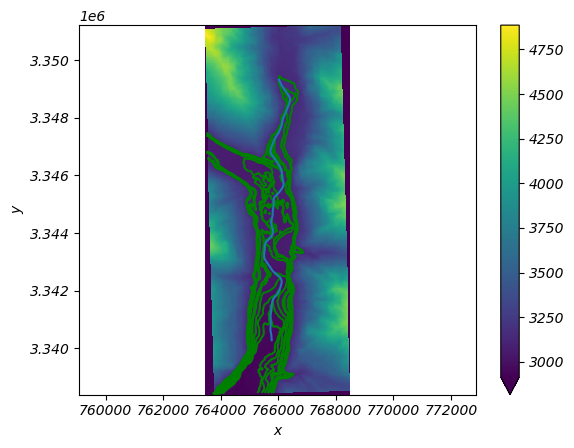

In [120]:

f, ax = plt.subplots()
for cg in cg1:
        for line in cg:
                ax.plot(line[:, 0], line[:, 1], color = 'green' )

plt.plot(*combinedLine.xy)
rasterValues = raster[:,:]
rasterValues = rasterValues.values.ravel()
vmin = rasterValues[rasterValues != -9999].min()
raster.plot(ax = ax, vmin = vmin)
plt.axis('equal')
plt.show()

In [ ]:
from run_confinement_values import calc_confinement_values
calc_confinement_values(df, file[-12:-4], directory, False, True)

(1018, 10183.093014749733)

In [ ]:
for i in np.linspace(0, combinedLine.length, int(combinedLine.length /10)):
    P = combinedLine.interpolate(i)
    P.distance()

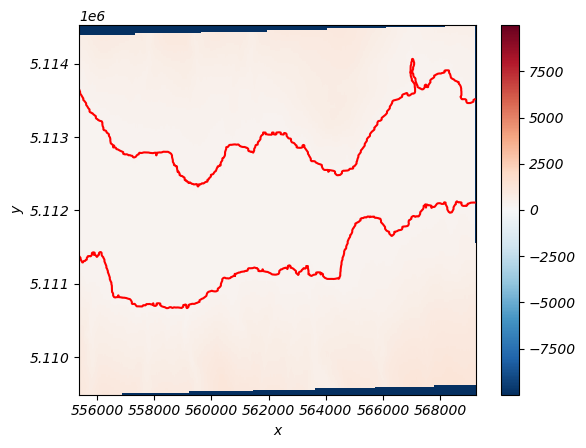

In [26]:
f, ax = plt.subplots()
for line in contours_geo:
    plt.plot(line[:, 0], line[:, 1], 'r-')
raster.plot(ax = ax)

# D

In [5]:

def apexWidth(apexP, dfN):
    dfApex = gpd.GeoDataFrame({'geometry':apexP.buffer(200)}, crs = reachCRS, index = [0])



    lineNodeJoin = gpd.sjoin_nearest(dfApex, dfN)
    bendNodes    = dfN[dfN.node_id.isin(lineNodeJoin.node_id.values)]
    return bendNodes['max_width'].mean()

def plotConnection(dfReach, localCRS, df, ax, zorder = 100):
    maxOrder = dfReach['reach_order'].max()

    for s, o, c, side, style in [['up', 0, 'red', 'upstream', '--'], ['dn', maxOrder, 'red', 'red', '--']]:
        rch = dfReach.loc[dfReach['reach_order'] == o, f'rch_id_{s}'].iloc[0]
        if isinstance(rch, list):
            dfS = df.loc[df.reach_id.isin(rch)]
            dfS = dfS.to_crs(localCRS)
            if side == 'upstream':
                dfS.plot(ax =ax, color = c, zorder = zorder, linewidth = 2, linestyle = style, label = 'Connecting Reach')
            else:
                dfS.plot(ax =ax, color = c, zorder = zorder, linewidth = 2, linestyle = style)
            # l = dfS.iloc[0].geometry
            # ax.plot(*l.xy, zorder = zorder,color =  'red')

def plotExtraLine(df, rid, localCRS):
    dfReach = df[df['reach_id'] == rid].copy()
    dfReach = dfReach.to_crs(localCRS)
    line = dfReach.iloc[0]['geometry']
    return line

3
0.14714089920248813 0.08736752038358409
Confinement Ratio (in, out):   2.45402 1.45712
Normalized slope (in, out):    0.13342 0.2247
Slope m/m (in, out):           0.08737 0.14714
max slope m/m :                0.65483
Slope degree (in, out):        8.37049 4.99311


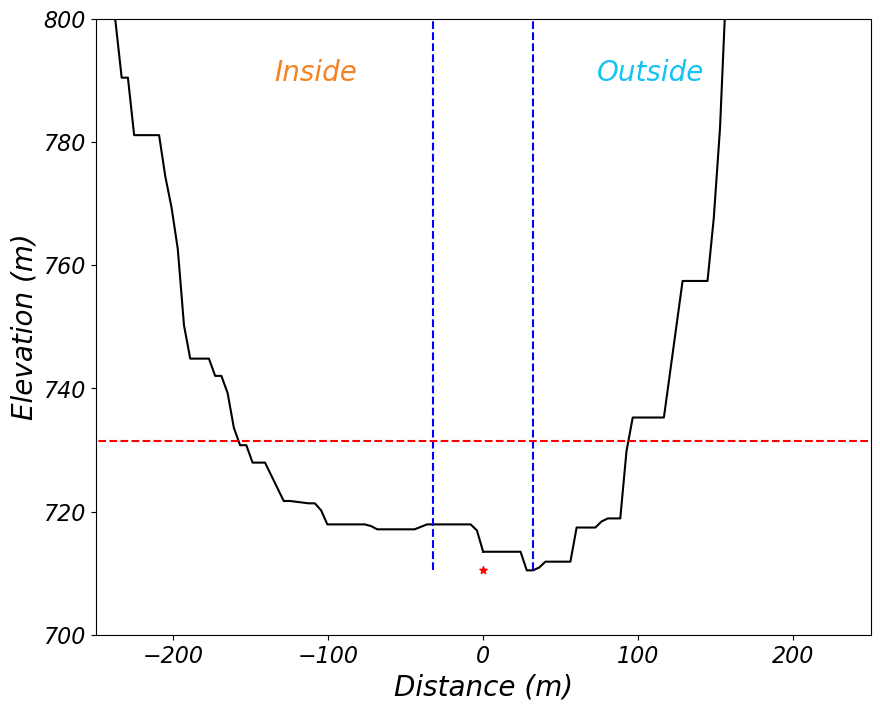

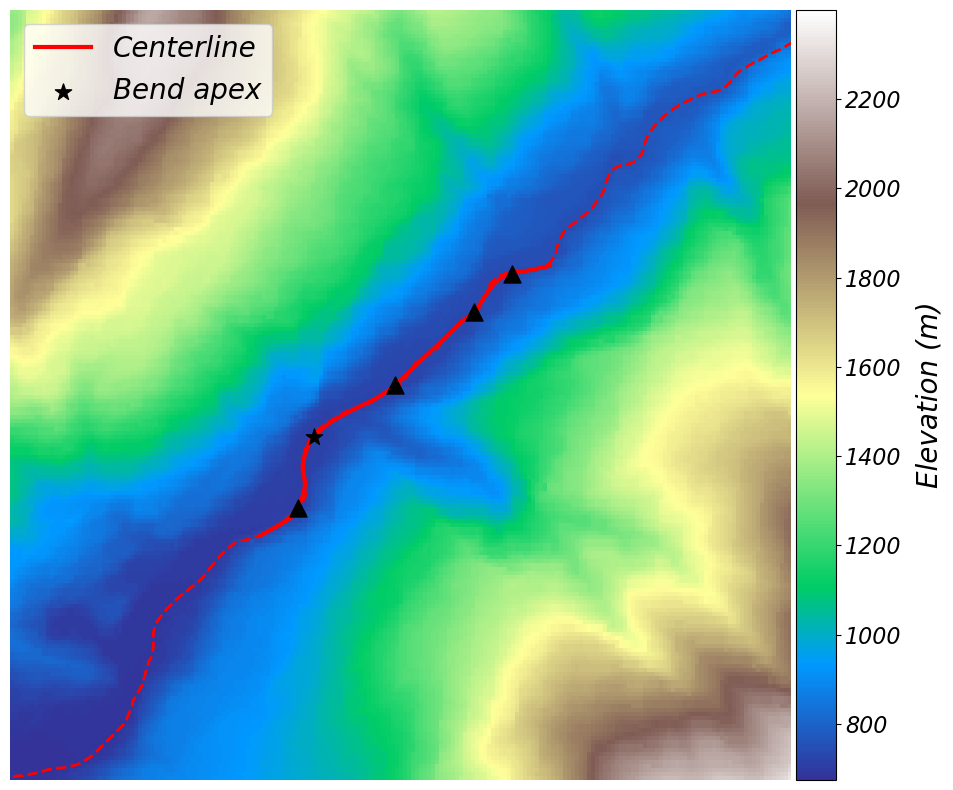

In [12]:
# for i in range(len(po)):
for i in range(3,4):
    print(i)
    plot(i, dfReach)
    print()
    print()
# plot(4, dfReach)

In [6]:
def plot(apexID,row):

    bendMW = bendMaxWidths[apexID]
    bendW  = bendWidths[apexID]

    heightFactor = 2
    factorRow       = abs(dfCF['bendWidths'] - bendW).argsort()
    # 4.429160868401368
    
    conFactor = dfCF.loc[factorRow.iloc[0], 'conFactor'] * heightFactor

    maxSlope = (2*conFactor*bendW) / (0.5*bendMW)


    (poIntercept, piIntercept,
     centerPointHeight, confinementHeight,
     slopeOut, slopeInn, EROut, ERInn) = confinement_values(po[apexID], pi[apexID], 
                                                cdo[apexID], cdi[apexID], 
                                                            bendW, bendMW, conFactor)
    
    slope_out_angle = (conFactor/0.5) * slopeOut
    if np.isnan(EROut):
        if slope_out_angle>0.1:
            print(apexID, slope_out_angle)

    rowcm = pd.DataFrame({'localCRS':reachCRS, 'bendMaxWidths':bendMW,'bendWidths':bendW, 
                        'bendLines':bendLines[apexID], 'conFactor':conFactor}, index = [0])
    r, r1, r2 = get_raster_side(combinedLine, demVRT, np.max(bendMW) * 2, reachCRS)
    (confDistance, confDistanceLeft, 
     confDistanceRight, bendHeight, 
     pLeft, pRight) = confinement_margin(rowcm.iloc[0], r, r1, r2, 2, heightFactor, 10)

    # print(slopeOut, slopeInn, EROut, ERInn)
    # print('slope:', np.rad2deg(np.arctan(slopeOut * maxSlope)), 
        #   np.rad2deg(np.arctan(slopeInn * maxSlope)))
for i in range(len(po)):
# for i in range(1,2):
    plot(i, dfReach)

In [11]:
def plot(apexID,row):
    def plot_prep(apexID):
        bendMW = bendMaxWidths[apexID]
        bendW  = bendWidths[apexID]

        heightFactor = 5
        factorRow       = abs(dfCF['bendWidths'] - bendW).argsort()
        # 4.429160868401368
        
        conFactor = dfCF.loc[factorRow.iloc[0], 'conFactor'] * heightFactor

        maxSlope = (conFactor*bendW) / (0.5*bendMW)

        
        (poIntercept, piIntercept,
        centerPointHeight, confinementHeight,
        slopeOut, slopeInn, EROut, ERInn) = confinement_values(po[apexID], pi[apexID], 
                                                    cdo[apexID], cdi[apexID], 
                                                                bendW, bendMW, conFactor)
        print(slopeOut * (conFactor/0.5), slopeInn * (conFactor/0.5))
        # rowcm = pd.DataFrame({'localCRS':reachCRS, 'bendMaxWidths':bendMW,'bendWidths':bendW, 
        #                     'bendLines':bendLines[apexID], 'conFactor':conFactor}, index = [0])
        # r, r1, r2 = get_raster_side(combinedLine, demVRT, np.max(bendMW) * 2, reachCRS)
        # (confDistance, confDistanceLeft, 
        # confDistanceRight, bendHeight, 
        # pLeft, pRight) = confinement_margin(rowcm.iloc[0], r, r1, r2, 2, heightFactor, 10)
        demWidth        = np.max(bendMW)
        raster = get_raster_vrt(demVRT, row, demWidth*25, reachCRS, DEMprojection)
        return (poIntercept, piIntercept,
        centerPointHeight, confinementHeight,
        slopeOut, slopeInn, EROut, ERInn, raster, maxSlope, bendW, bendMW)
    
    (poIntercept, piIntercept,
        centerPointHeight, confinementHeight,
        slopeOut, slopeInn, EROut, ERInn, raster, maxSlope, bendW, bendMW) = plot_prep(apexID)
    
    print('Confinement Ratio (in, out):'.ljust(30), np.round(ERInn,5), np.round(EROut,5))
    print('Normalized slope (in, out):'.ljust(30), np.round(slopeInn,5), np.round(slopeOut, 5))
    print('Slope m/m (in, out):'.ljust(30), np.round(slopeInn * maxSlope,5), np.round(slopeOut * maxSlope, 5))
    print('max slope m/m :'.ljust(30), np.round(maxSlope,5))
    print('Slope degree (in, out):'.ljust(30), np.round(np.rad2deg(np.arctan(slopeOut * maxSlope)),5), np.round(np.rad2deg(np.arctan(slopeInn * maxSlope)), 5))


    #####
    # plot settings:
    axis_label_size = 20
    axis_tick_size  = 16

    outsideColor = 'silver'
    innsideColor = 'dimgray'

    ############################################################
    ############################################################
    # Figure 1
    ############################################################
    ############################################################
    minH = min(min(pi[apexID]), min(po[apexID]))
    maxH = max(max(pi[apexID]), max(po[apexID]))

    f, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = [10,8])
    ax1.plot(cdo[apexID]             , po[apexID], color = 'black', zorder = 0)
    ax1.plot(np.array(cdi[apexID])*-1, pi[apexID], color = 'black', zorder = 0)


    ##################### 
    # Slope lines
    if np.isnan(EROut) == False:
        yo = [centerPointHeight, confinementHeight]
        xo = [0, poIntercept]

    else:
        yo = centerPointHeight + slopeOut * (cdo[apexID] - cdo[apexID][0])
        xo = cdo[apexID]
        
    if np.isnan(ERInn) == False:
        yi = [centerPointHeight, confinementHeight]
        xi = [0, piIntercept*-1]
        
    else:
        yi = centerPointHeight + slopeInn * (cdi[apexID] - cdi[apexID][0])
        xi = np.array(cdi[apexID])*-1
    # ax1.plot(xo, yo, color = 'blue', label = f'Out: {slopeOut}', zorder = 200)
    # ax1.plot(xi, yi, color = 'blue', label = f'In: {slopeInn}' , zorder = 200)
    #####################
    # River extend lines
    ax1.vlines(bendMW/2  , minH, maxH, linestyle = '--', color = 'blue', zorder = 10)
    ax1.vlines((bendMW/2)*-1, minH, maxH, linestyle = '--', color = 'blue', zorder = 10)


    #####################
    # confinement height line
    ax1.hlines(confinementHeight, max(cdo[apexID])*-1, max(cdi[apexID]), linestyle = '--', color = 'red', zorder = 100)

    #####################
    # River centerpoint
    ax1.scatter(0, centerPointHeight, marker = '*', c = 'red', s = 30
                , zorder = 500)

    # Normal text position
    # loc = [0.6,1]
    # ax1.text(cdo[apexID][-1]*loc[0] , maxH *loc[1], "Outside", fontsize=axis_label_size, color='black', ha="center")
    # ax1.text(cdi[apexID][-1]*-loc[0], maxH *loc[1], "Inside" , fontsize=axis_label_size, color='black', ha="center")

    # zoomed text
    loc = [0.6,1]
    ax1.text(180*loc[0] , 790 *loc[1], "Outside", fontsize=axis_label_size, color='#12C3F4', ha="center", zorder = 300)
    ax1.text(180*-loc[0], 790 *loc[1], "Inside" , fontsize=axis_label_size, color='#F58220', ha="center", zorder = 300)

    ax1.set_xlim([-250, 250])
    ax1.set_ylim([700, 800])

    #labels
    ax1.set_xlabel('Distance (m)'  , fontsize = axis_label_size)
    ax1.set_ylabel('Elevation (m)' , fontsize = axis_label_size)
    # Customize tick size and color
    ax1.tick_params(axis='both', which='major', labelsize=axis_tick_size, colors='black')  # Major ticks
    
    # plt.legend()
    plt.show()


    ############################################################
    ############################################################
    # Figure 2
    ############################################################
    ############################################################
    f, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = [10,8])
    pointSize = 150


    ax2.plot(*combinedLine.xy, zorder =10, color = 'red', linewidth = 3, label = 'Centerline')
    # plotConnection(dfReach,reachCRS, df, ax2)

    for i, ap in enumerate(apexPList):
        if i != apexID:
            ax2.scatter(*ap.xy, c = 'black', marker = '^', zorder = 100, s= pointSize)
    ax2.scatter(*apexPList[apexID].xy, c = 'black', marker = '*', zorder = 1000, s = pointSize, label = 'Bend apex')


    ##############################
    # Cross lines
    # ax2.plot(*lineOut[apexID].xy, color = outsideColor, label = 'Outside')
    # ax2.plot(*lineInn[apexID].xy, color = innsideColor, label = 'Inside')


    for rid in [21602600716, 21602600694, 21602600681, 21602600701, 21602600674, 21602600661]:
        L = plotExtraLine(df, rid, reachCRS)
        ax2.plot(*L.xy, linewidth = 2, color = 'red', linestyle = '--')


    

    # lineLeft  = LineString(pLeft)
    # lineRight = LineString(pRight)
    # print(lineLeft, lineRight)
    # ax2.plot(*lineLeft.xy, zorder = 100, color = 'black')
    # ax2.plot(*lineRight.xy, zorder = 100, color = 'black')
    # for p in pLeft:
    #     ax2.scatter(*p, marker = 4, s = 100, zorder = 100000)
    # for p in pRight:
    #     ax2.scatter(*p, marker = 4, s = 100, zorder = 100000)


    ax2.set_aspect('equal')
    ax2.axis('off')

    # plot Raster
    rasterValues = raster[:,:]
    rasterValues = rasterValues.values.ravel()
    vmin = rasterValues[rasterValues != -9999].min()
    im = raster.plot(ax = ax2, vmin = vmin, vmax = raster.max(), cmap = 'terrain', zorder = 0,
                add_colorbar=False)
    ax2.set_title('')



    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, shrink=0.8, aspect=10)
    cbar.ax.tick_params(labelsize=axis_tick_size)  # Adjust tick label text size
    cbar.set_label('Elevation (m)', fontsize=axis_label_size, labelpad=10)
    ax2.legend(fontsize = axis_label_size)

    # Get current limits
    x0, x1 = ax2.get_xlim()
    y0, y1 = ax2.get_ylim()

    # Percentage to trim
    trim_pct = 0.02  # 2%

    # Adjust limits by trimming a percentage
    x_range = x1 - x0
    y_range = y1 - y0

    ax2.set_xlim(x0 + x_range * trim_pct, x1 - x_range * trim_pct)
    ax2.set_ylim(y0 + y_range * trim_pct, y1 - y_range * trim_pct)

    plt.tight_layout()
    plt.savefig(directory + 
                f'results/figures/methods_1_{c}_{i}_{dfReach.iloc[0].combined_reach_id}.png')
    plt.show()



# Test New valley edge method

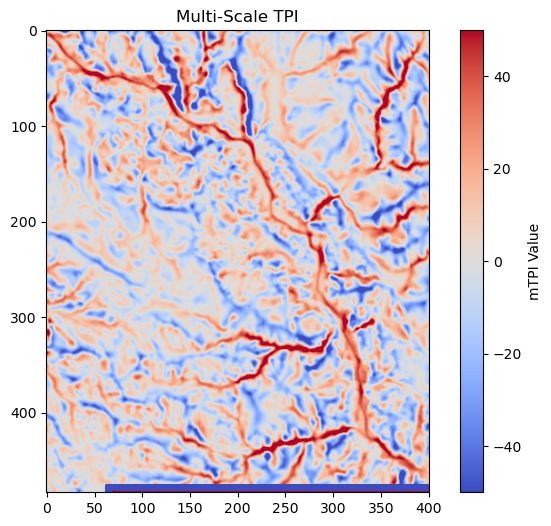

In [46]:
import numpy as np
import rasterio
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt

def calculate_mTPI(dem_array, small_window=3, large_window=15):
    """
    Compute multi-scale Topographic Position Index (mTPI).
    
    Args:
        dem_array (numpy.ndarray): The input DEM as a NumPy array.
        small_window (int): Size of the small neighborhood window.
        large_window (int): Size of the large neighborhood window.

    Returns:
        numpy.ndarray: The computed mTPI.
    """
    
    def mean_filter(array, size):
        return generic_filter(array, np.nanmean, size=size, mode='nearest')

    # Compute mean elevation at different scales
    mean_small = mean_filter(dem_array, small_window)
    mean_large = mean_filter(dem_array, large_window)

    # Compute TPI at different scales
    tpi_small = dem_array - mean_small
    tpi_large = dem_array - mean_large

    # Combine the two scales (adjust weights as needed)
    mTPI = tpi_small - tpi_large
    return mTPI

# F = glob.glob(directory + 'input/FAB_dem/*')[10]# Load DEM
# with rasterio.open(F) as src:
#     dem = src.read(1)  # Read DEM as a NumPy array
#     profile = src.profile  # Save metadata for writing output

# Compute mTPI
mTPI_result = calculate_mTPI(raster[0,:,:].values, small_window=3, large_window=15)

# Compute mTPI
# mTPI_result = calculate_mTPI(dem, small_window=3, large_window=15)

# Save the result as a new raster
# output_path = directory + "input_created/mTPI_30m.tif"
# with rasterio.open(output_path, "w", **profile) as dst:
#     dst.write(mTPI_result, 1)

# Plot the mTPI
plt.figure(figsize=(8, 6))
plt.imshow(mTPI_result, cmap='coolwarm', vmin=-50, vmax=50)
plt.colorbar(label="mTPI Value")
plt.title("Multi-Scale TPI")
plt.show()


In [65]:
mTPI_result.max()

4989.117

In [48]:
# Save as GeoTIFF
output_tif = directory + "input_created/mTPI_30m.tif"
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=mTPI_result.shape[0],
    width=mTPI_result.shape[1],
    count=1,  # Single-band raster
    dtype=mTPI_result.dtype,
    crs=raster.rio.crs,
    transform=raster.rio.transform(),
) as dst:
    dst.write(mTPI_result, 1)  # Write adjusted array

In [50]:
import rioxarray

In [88]:
NF = glob.glob(directory + 'input_created/mTPI_30m.tif')[0]
R = rioxarray.open_rasterio(NF) 

In [58]:
rasterValues = R[0,:,:]
rasterValues = rasterValues.values.ravel()
vmin = rasterValues[rasterValues != -5788.9126].min()

In [64]:
v = rasterValues[rasterValues != -5788.9126]
v[v != -5788.0796].min()


-5787.5586

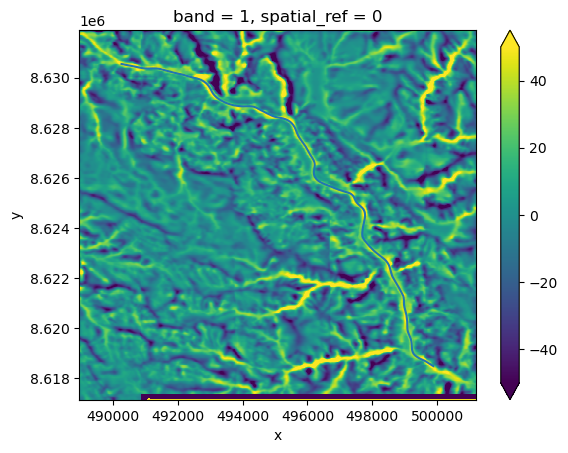

In [68]:
f, ax = plt.subplots()
R.plot(vmin = -50, vmax = 50, ax = ax)
ax.plot(*combinedLine.xy)

In [90]:
RV.min(),RV.max()

(-5788.9126, 4989.117)

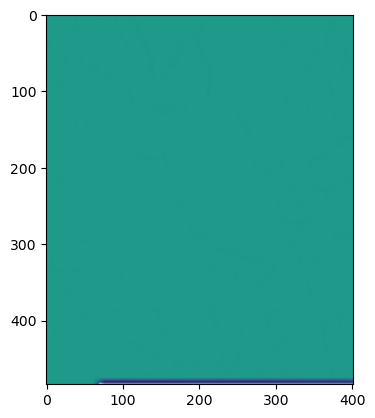

In [89]:
RV = R[0,:,:].values
RV[RV< -0.75]
plt.imshow(RV)

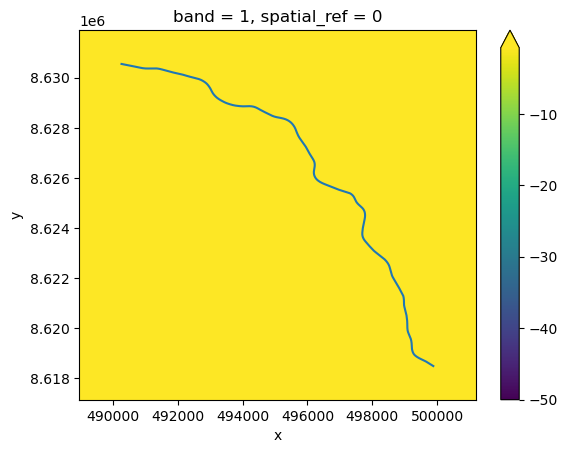

In [76]:
f, ax = plt.subplots()
R.plot(vmin = -50, vmax = -0.75, ax = ax)
ax.plot(*combinedLine.xy)

In [ ]:
dfTest = 

[62100100386]

# Test confinement margin

In [24]:
DEMcmap = create_custom_cmap(['_'], True)



In [14]:
def get_raster_coordinates(raster):
    x = raster.x.values
    y = raster.y.values
    xx, yy = np.meshgrid(x, y)
    coords = np.column_stack([xx.ravel(), yy.ravel()])
    return coords

# Find the closest point with a specific elevation relative to the line
def find_raster_points_threshold(dem, target_elevation):
    # Get DEM coordinates
    dem_coords = get_raster_coordinates(dem)
    
    # Get elevation data
    dem_elevations = dem.values.ravel()
    # Filter out points that are not at the target elevation
    valid_points = np.where(dem_elevations > target_elevation)[0]

    if len(valid_points) == 0:
        raise ValueError(f"No points with elevation {target_elevation} found.")
    
    valid_coords = dem_coords[valid_points]
    
    # Use cKDTree for fast nearest neighbor search
    tree = cKDTree(valid_coords)
    return tree, valid_coords


In [15]:
def find_raster_sides(DFRow, bufferMultiplier, plot):
    dfRow = DFRow.copy()
    dsRow = dfRow.iloc[0]
    line  = dsRow.geometry

    demBufferSize = dsRow.node_mwm*bufferMultiplier
    DEMRaster = find_dem(dfRow, directory, projection, demBufferSize, False).squeeze()

    demBox = Box(*line.buffer(demBufferSize).bounds)
    demBoxRing = demBox.exterior
    boxConnectStart = demBoxRing.interpolate(demBoxRing.project(Point(line.coords[0 ])))
    boxConnectEnd   = demBoxRing.interpolate(demBoxRing.project(Point(line.coords[-1])))
    
    splitLineCoords = list(line.coords)
    splitLineCoords.insert(0, boxConnectStart.coords[0])
    splitLineCoords.append(boxConnectEnd.coords[0])
    splitLine = LineString(splitLineCoords)

    splitBox = shapely.get_parts(split_ring(demBoxRing, splitLine))
    polySide1 = Polygon(shapely.line_merge(MultiLineString([splitBox[0], splitLine])))
    polySide2 = Polygon(shapely.line_merge(MultiLineString([splitBox[1], splitLine])))
        

    rasterSide1 = DEMRaster.rio.clip([polySide1])
    rasterSide2 = DEMRaster.rio.clip([polySide2])

    if plot == True:
        f, ax = plt.subplots(nrows = 1, ncols =3, figsize = [15,5], sharey = True)

        R  = DEMRaster.copy()
        RV = R.values
        RV[RV == -9999] = np.nan
        R.values = RV


        R.plot(ax = ax[0], cmap = DEMcmap, vmin = R.min(), vmax = R.max())

        ax[0].plot(*polySide1.exterior.xy)
        ax[0].plot(*polySide2.exterior.xy)


        side1  = rasterSide1.copy()
        side1V = side1.values
        side1V[side1V == -9999] = np.nan
        side1.values = side1V
        side2  = rasterSide2.copy()
        side2V = side2.values
        side2V[side2V == -9999] = np.nan
        side2.values = side2V

        side1.plot(ax = ax[1], cmap = DEMcmap,vmin = R.min(), vmax = R.max(), add_colorbar = False)
        side2.plot(ax = ax[2], cmap = DEMcmap,vmin = R.min(), vmax = R.max(), add_colorbar = False)

        ax[0].set_ylabel('Latitude (m)')
        ax[1].set_ylabel('')
        ax[2].set_ylabel('')
        ax[0].set_xlabel('Longitude (m)')
        ax[1].set_xlabel('Longitude (m)')
        ax[2].set_xlabel('Longitude (m)')
        ax[0].set_title('')
        ax[1].set_title('')
        ax[2].set_title('')


        ax[0].plot(*line.xy, 'black')
        ax[1].plot(*line.xy, 'black')
        ax[2].plot(*line.xy, 'black')
        f.suptitle('DEM')
        plt.tight_layout()
        plt.show()
    
    return DEMRaster, rasterSide1, rasterSide2



In [16]:

def valley_width_from_threshold(DFRow,bufferMultiplier,depths, plot = True):
    tm1 = dt.now()
    
    dfRow = DFRow.copy()
    dsRow = dfRow.iloc[0]
    line  = dsRow.geometry

    DEMRaster, raster1, raster2 = find_raster_sides(dfRow, bufferMultiplier, plot)
    threshold = 4.66
    threshold = np.nanmean(depths) *2
    
    tm2 = dt.now()
    print('First: ',  tm2-tm1)
    try:
        tree1, coords1 = find_raster_points_threshold(raster1, threshold)
        tree2, coords2 = find_raster_points_threshold(raster2, threshold)
    except:
        print('No Confinement')
        return 99999
    
    tm3 = dt.now()
    print('Second: ', tm3-tm2)
    if plot == True:
        f, ax = plt.subplots()

    distances = []
    for i in np.arange(0,1.1,0.01):
        targetPoint = line.interpolate(i, normalized = True)
        TQ1 = tree1.query(targetPoint.coords[0])
        TQ2 = tree2.query(targetPoint.coords[0])

        P1 = Point(coords1[TQ1[1]])
        P2 = Point(coords2[TQ2[1]])
        distances.extend([TQ1[0], TQ2[0]])
        if plot == True:
            ax.scatter(*targetPoint.xy, s = 40, c = 'black', zorder = 100, marker = "^")
            ax.scatter(*P1.xy, s = 40, c = 'maroon', zorder = 100)
            ax.scatter(*P2.xy, s = 40, c = 'deeppink', zorder = 100)
    if plot == True:
        DEMRaster.plot(ax = ax, cmap = DEMcmap)
        plt.title(f'Closest Points with threshold value: {threshold}')
        plt.xlabel(f'x coordinate (m)')
        plt.ylabel(f'y coordinate (m)')
        ax.plot(*line.xy, 'black')
        plt.show()
    tm4 = dt.now()

    print('Third: ', tm4-tm3)
    return np.nanmean(distances)




# Find matching bankfull Depth

In [15]:
def mesh_coordinates(x, y):
    """Create zipped coordinates from separate x & y coordinates\n
    input: \n
        x: list of longitudes\n
        y: list of latitudes\n
    return: Coordinates pairs in grid 
    """
    xx, yy = np.meshgrid(x, y)
    coords = np.column_stack([xx.ravel(), yy.ravel()])
    return coords


In [16]:
def open_bankfull_depth(directory:'str'):
    """Open bankfull depth file and create spatial index tree for fast spatial matches\n
    input: \n
        directory: main folder directory\n
    return: \n
        - bankfull depth variable
        - longitude values in array
        - latitude values in array
        - meshgrid of lon & lat values (indices match tree)
        - spatial tree of lon lat values
    """
    bankfullDepthFile = directory + 'input/bankfull/bankfull_depth_global.nc'
    ncDepth = netCDF4.Dataset(bankfullDepthFile)

    lon   = ncDepth.variables['lon'][:].tolist()
    lat   = ncDepth.variables['lat'][:].tolist()
    depth = ncDepth.variables['bankfull_depth']

    depthCoords = mesh_coordinates(lon,lat)

    depthTree = cKDTree(depthCoords)

    return depth, np.array(lon), np.array(lat), depthCoords, depthTree


In [17]:
def find_bankfull_depth(DFRow :'gpd.GeoDataFrame',projection,projectionDegree, depth, depthTree:'cKDTree', depthlon, depthlat, depthCoords):
    dfRow = DFRow.copy()

    dfRow = dfRow.to_crs(projectionDegree)
    dsRow = dfRow.iloc[0]
    linep  = dsRow.geometry 
    
    dfAP = gpd.GeoDataFrame({'geometry':dsRow.apexP5_0}, crs = projection)
    dfAP = dfAP.to_crs(projection_coord)

    depthList = []
    for i, ap in dfAP.iterrows():
        apCoords = ap.geometry.coords[0]
        # apCoords = linep.interpolate(0.5, normalized = True).coords[0]
        
        dist, ind = depthTree.query(apCoords, k = 10)
        
        vals = []
        for i in ind:
            x, y = depthCoords[i]

            xpos = abs(depthlon - x).argmin()
            ypos = abs(depthlat - y).argmin()

            val = depth[ypos, xpos]

            if val > 1: #make sure the depth value are more than 1 (fail save for values in river)
                vals.append(val)
        if len(vals) == 0:
            print('Error no values above 0')
        d = np.mean(vals) 
        depthList.append(d)

    return depthList
    


# Run


In [38]:
bankfulldepth, bankfulllon, bankfulllat, depthCoords, depthTree = open_bankfull_depth(directory)

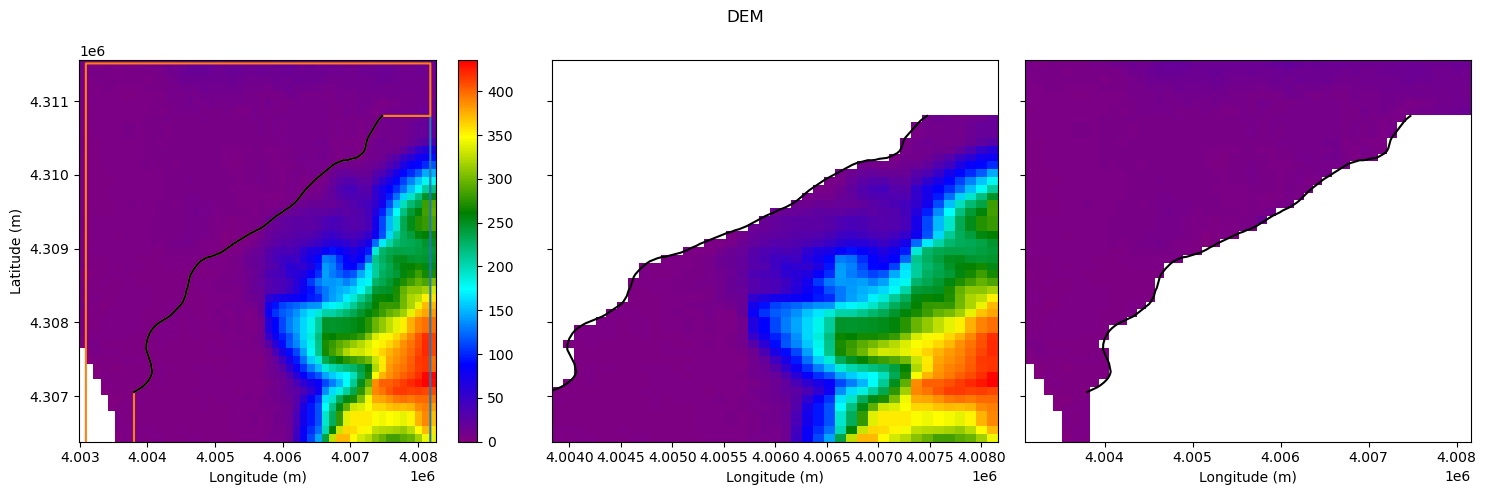

First:  0:00:02.423409
No Confinement


99999

In [13]:
dfP = df.copy()
i = 0
row= dfP[dfP.reach_id == dfP.iloc[i].reach_id]
# reachDepths = find_bankfull_depth(row, projection, projection_coord, bankfulldepth, depthTree, bankfulllon, bankfulllat, depthCoords)
valley_width_from_threshold(row,10, 10, True)

# Get entrenchement ratio

In [35]:
A = np.array([1,3,2,5])
print(np.mean(A/4))
print(np.mean(A)/4)

0.6875
0.6875


In [36]:
def vw_one_side(hp, d, threshold):
    dh = list(zip(d, hp))
    dt = list(zip(d, [threshold + hp[0]] * len(d)))
    dhLine = LineString(dh)
    dtLine = LineString(dt)

    if dhLine.intersects(dtLine):
        inter = dhLine.intersection(dtLine)
        x     = shapely.get_coordinates(inter)[:,0]
        vw    = abs(x).min()
    else:
        vw = np.nan
    return vw, dhLine, dtLine

def valley_width(hp1, hp2, d,width, threshold, plot = True):
    if (isinstance(hp1, int)):
        vw1 = np.nan
    else:
        vw1, lh1, lt1 = vw_one_side(hp1,d, threshold)
    if (isinstance(hp2, int)):
        vw2 = np.nan
    else:    
        vw2, lh2, lt2 =vw_one_side(hp2,d, threshold)
    


    if (np.isnan(vw1)) & (np.isnan(vw2)):
        confSingle = np.nan
    elif ((np.isnan(vw1)) & (np.isnan(vw2) == False)) | ((np.isnan(vw2)) & (np.isnan(vw1) == False)):
        confSingle = True
    else:
        confSingle = False
    

    if plot == True:
        f, ax = plt.subplots(nrows=1, ncols = 1, figsize = (12,5))
        ax.plot(*lh1.xy, color = 'blue')
        ax.plot(*lt1.xy, color = 'limegreen', linestyle = ':')

        h1 = np.array(lh1.coords)
        h2 = np.array(lh2.coords)
        t2 = np.array(lt2.coords)

        ax.plot(h2[:,0] *-1, h2[:,1], color = 'blue', label = 'Height profile')
        ax.plot(t2[:,0] *-1, t2[:,1], color = 'limegreen', label = 'Valley Threshold', linestyle = ':')

        ax.vlines(0,np.min([h1[:,1].min(), h2[:,1].min()]), np.max([h1[:,1].max(), h2[:,1].max()]), linestyle = '--', color = 'lightsteelblue', label = 'Centerline')
       
        ax.set_xlabel('Distance (m)')
        ax.set_ylabel('Height (m)')
        if (np.isnan(vw1)) & (np.isnan(vw1)):
            vwT = 'No Confinement'
        elif (np.isnan(vw2)) & (np.isnan(vw1) == False):
            vwT = f'ValleyWidth: {int(vw1)}'
        elif (np.isnan(vw1)) & (np.isnan(vw2) == False):
            vwT = f'ValleyWidth: {int(vw2)}'
        else:
            vwT = f'ValleyWidth: {int(vw1 + vw2)} ({int(vw1)}, {int(vw2)})'

        ax.set_title(vwT)
        plt.legend()
    
    vw = np.nansum([vw1,vw2])
    return vw, vw / width, confSingle

In [50]:
def vw_one_side(hp, d, threshold):
    dh = list(zip(d, hp))
    dt = list(zip(d, [threshold + hp[0]] * len(d)))
    dhLine = LineString(dh)
    dtLine = LineString(dt)

    if dhLine.intersects(dtLine):
        inter = dhLine.intersection(dtLine)
        x     = shapely.get_coordinates(inter)[:,0]
        vw    = abs(x).min()
    else:
        vw = np.nan
    return vw, dhLine, dtLine
def alternative_entrenchment_ratio(hp1List, hp2List, dInnList,width, threshold, plot):
    # change so that minimal value is searched for in between the river banks
    vwList = []
    if (isinstance(hp1List, list) == False) | (isinstance(hp1List, list) == False):
        return np.nan
    for i in range(len(hp1List)):
        hp1  = hp1List[i]
        hp2  = hp2List[i]
        dInn = dInnList[i]
        print(hp1)
        print(all(np.isnan(hp1)))
        print(all(np.isnan(hp2)))
        if (all(np.isnan(hp1))) & (all(np.isnan(hp2))):
            vw = np.nan
            vwList.append(vw)
        elif (all(np.isnan(hp1))) & (all(np.isnan(hp2)) == False):
            # vw,_,_ = vw_one_side(hp2, dInn, threshold)
            # if np.isnan(vw):
            #     confSingle = np.nan
            # else:
            #     confSingle = True
            # vwList.append(vw)
            vw = np.nan
            vwList.append(vw)
        elif (all(np.isnan(hp1)) == False) & (all(np.isnan(hp2))):
            # vw,_,_ = vw_one_side(hp1, dInn, threshold)
            # if np.isnan(vw):
            #     confSingle = np.nan
            # else:
            #     confSingle = True
            # vwList.append(vw)
            vw = np.nan
            vwList.append(vw)
        else:
            pr = np.array(hp1.copy())
            d  = np.array(dInn.copy())
            pr = np.flip(pr, 0)
            pr = np.append(pr, hp2)

            d = d * -1
            d = np.flip(d, 0)
            d = np.append(d, dInn)

            threshold = width[i]

            halfWidth = width[i] /2

            riverarea = np.where((d > (-1*halfWidth)) & (d < halfWidth))[0]
            
            prRiver = pr.copy()
            prRiver = prRiver[riverarea]
            prThreshold = prRiver.min()
            
            prminId = np.where(prRiver == prThreshold)[0]
            A = prminId[int(len(prminId) / 2)]
            centerDist = d[riverarea[A]]

            dh = list(zip(d, pr))
            dt = list(zip(d, [threshold + prThreshold] * len(d)))
            dhLine = LineString(dh)
            dtLine = LineString(dt)




            if dhLine.intersection(dtLine):
                inter = dhLine.intersection(dtLine)
                x = shapely.get_coordinates(inter)[:,0]
                cond = x > centerDist

                if (all(cond)) | (not any(cond)):
                    x1 = abs(x).min() - centerDist
                    x2 = np.max(dInn)
                    vw = x1 + x2
                    confSingle = True
                else:
                    x1, x2 = [x[cond], x[~cond]]
                    x1 = x1.min()
                    x2 = x2.max()
                    vw = abs(np.diff([x1,x2])[0])
                    confSingle = False
            else:
                vw = np.max(dInn) * 2
                
                confSingle = np.nan
            
            vwList.append(vw)

        if (plot == True) & (~np.isnan(vw)):
            print(i, vw)
            f, ax = plt.subplots(nrows =1, ncols = 1, figsize = [12,5])

            ax.plot(*dhLine.xy, color = 'blue', label = 'Height profile')
            ax.plot(*dtLine.xy, color = 'limegreen', linestyle = ':', label = 'Valley Threshold')

            if np.isnan(vw):
                ax.set_title('No Confinement')
            else:
                ax.set_title(int(vw))
            
            ax.vlines(0,np.min(pr), np.max(pr), linestyle = '--', color = 'lightsteelblue', label = 'Centerline')     # centerline
            ax.vlines(d[riverarea[0]],np.min(pr), np.max(pr), linestyle = '--', color = 'red',label = 'River border')  # riverborder
            ax.vlines(d[riverarea[-1]],np.min(pr), np.max(pr), linestyle = '--', color = 'red') #riverborder
            ax.scatter(centerDist, prThreshold , marker = '*', label = 'New center', c = 'black', s = 70, zorder = 500)
            plt.legend()
            plt.show()
    
    entrenchmentRatio = np.nanmean(np.array(vwList) / width)

    return entrenchmentRatio

0
[520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 520.8628, 516.92957, 516.92957, 512.99634, 512.99634, 512.99634, 512.99634, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 509.06308, 521.013, 521.013, 521.013, 521.013, 521.013, 521.013, 521.013, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 532.9628, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 544.9127, 565.988, 565.988, 565.988, 565.988, 565.988, 565.988, 

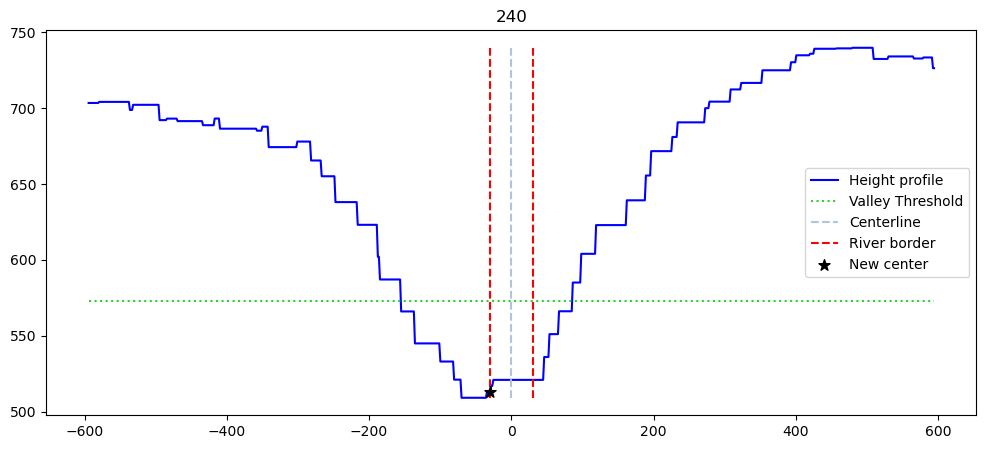

[510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 510.21896, 515.55023, 515.55023, 520.88153, 520.88153, 520.88153, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277, 526.21277

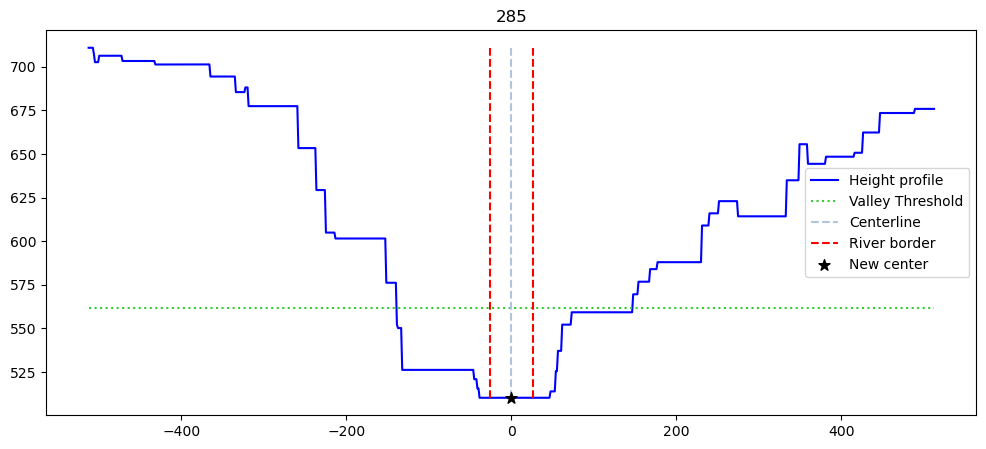

[511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 511.40088, 525.0925, 525.0925, 525.0925, 525.0925, 525.0925, 538.7842, 538.7842, 538.7842, 538.7842, 538.7842, 538.7842, 538.7842, 538.7842, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 552.4759, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 562.42487, 56

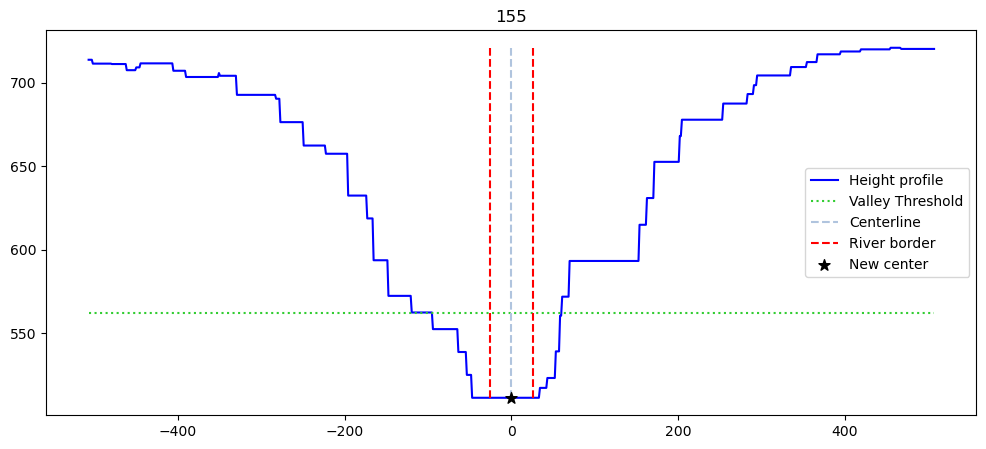

[516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 516.9969, 528.3123, 550.3344, 550.3344, 550.3344, 550.3344, 572.35645, 572.35645, 585.29584, 585.29584, 585.29584, 585.29584, 585.29584, 608.9417, 608.9417, 608.9417, 608.9417, 608.9417, 608.9417, 608.9417, 608.9417, 608.9417, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 621.8811, 62

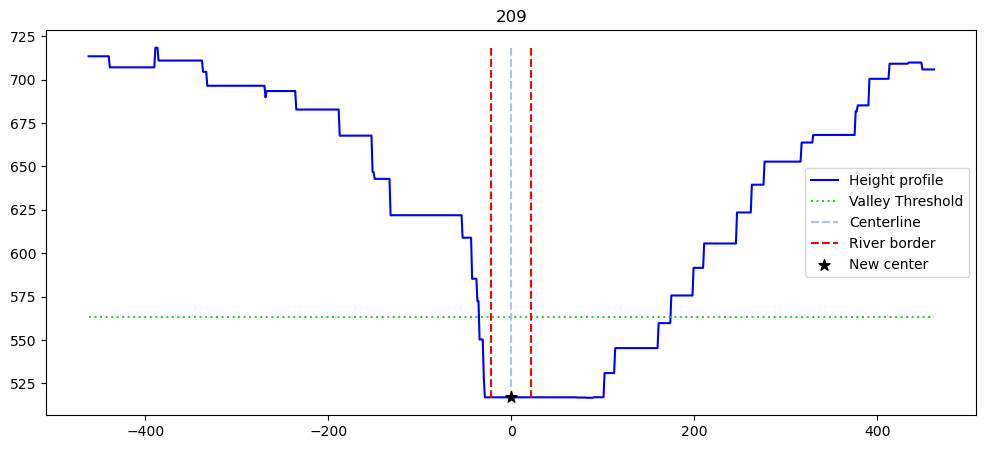

[521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.0192, 521.6826, 521.6826, 521.6826, 521.6826, 522.34595, 522.34595, 522.34595, 520.98285, 520.98285, 520.98285, 520.98285, 520.98285, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 532.3135, 5

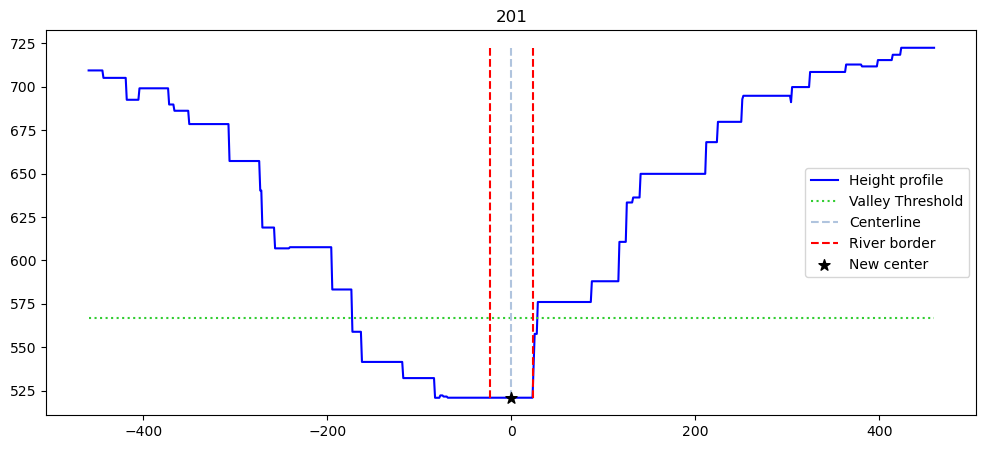

[551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 551.8893, 527.24554, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 514.92365, 530.8962, 546.86865, 546.86865, 546.86865, 546.86865, 546.86865, 562.8412, 562.8412, 562.8412, 562.8412, 562.8412, 562.8412, 

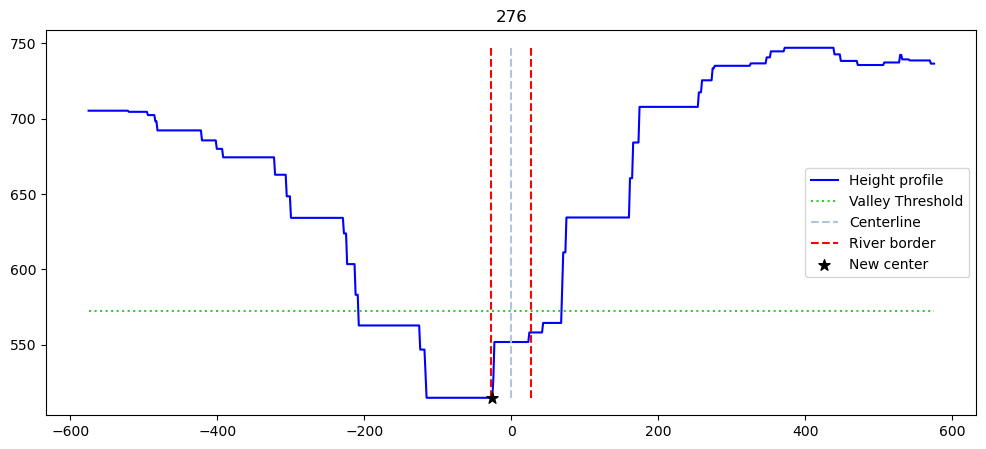

[536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 536.5462, 556.3528, 556.3528, 556.3528, 576.15936, 576.15936, 576.15936, 576.15936, 576.15936, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 595.9659, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 600.9365, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.9072, 605.

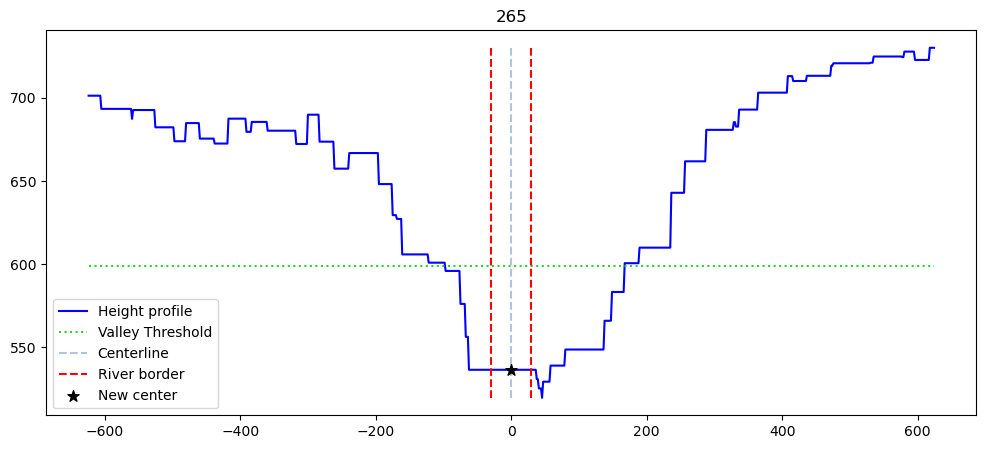

In [62]:


rt =0
# row = dfT[dfT.reach_id == dfT.iloc[rt].reach_id].iloc[0]
# row = dfT[dfT.reach_id == rows.iloc[0].reach_id].iloc[0]
rows = dfT[dfT.mInnOutSlope == dfT.mInnOutSlope.max()]
rows = dfT[dfT.reach_id == 11497000041]
# rows = dfT[dfT.ER == dfT.ER.min()]
# ids = [11497000071, 11410000021,11430000041, 11430000011]
# ids = dfT.iloc[52:53].reach_id.values
ids = rows.reach_id.values

# ids = rows[rows.reach_id == 31320100041].reach_id.values
# print(ids)
# ids = dfT.reach_id.values
m1 =[]
m2 = []
M1,M2 = [],[]
for i, id in enumerate(ids):
    print(i)
    reach = dfT[dfT.reach_id == id]
    row = reach.iloc[0]
    
    # row = rows.iloc[0]
    width     = row.bendWidths
    threshold = 0

    outpr = row.outPR
    innpr = row.innPR
    dists = row.CDists
    m1.append([])
    m2.append([])
    

        # vw1,vw1F, confSingle1  =  valley_width(opr, ipr, dists,width, threshold, plot = False)
        # m1[i].append(vw1F)

    ER = alternative_entrenchment_ratio(innpr, outpr, dists,width, threshold, plot = True)
        # print(vw2)
        # m2[i].append(vw2F)
    # print(np.nansum(m1))
    # M1.append(np.nanmean(m1[i]))
    # M2.append(np.nanmean(m2[i]))
        
        

In [63]:
dfT[['reach_id', 'ER', 'File']].sort_values('ER')

,reach_id,ER,File
261,11497000051,2.987153,af_11
593,17249100011,4.266041,af_17
260,11497000041,4.369407,af_11
257,11496000071,4.479477,af_11
262,11497000061,4.532616,af_11
...,...,...,...
1108,18193600021,NaN,af_18
1186,18194000241,NaN,af_18
1358,18197600021,NaN,af_18
1363,18197600081,NaN,af_18


In [239]:
M1

[]

In [53]:
for i in range(len(m1)):
    M1 = m1[i]
    M2 = m2[i]
    # print(M1, np.std(M1), np.mean(M1))
    # print(M2, np.std(M2), np.mean(M2))
    print(np.mean(M1))
    print(np.mean(M2))
    print()

nan
nan

nan


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (9, 2) + inhomogeneous part.

In [141]:
for i in range(len(m1)):
    M1 = m1[i]
    M2 = m2[i]
    # print(M1, np.std(M1), np.mean(M1))
    # print(M2, np.std(M2), np.mean(M2))
    print(np.mean(M1))
    print(np.mean(M2))
    print()

[171.62227906705152, 91.96595608465982, 133.8371369224016, 76.70787400044895, 193.9047779931363, 278.1073116167738] 67.6420249479469 157.69088928074532
[90.55911240357051, 91.74414145020053, 122.46537976063, 76.70787400044895, 89.90828172072638, 89.69052706364145] 13.905107923516812 93.51255273320298

[458.6316843156975, 189.39083852944805, 267.4460885819212, 184.3767643776321, 328.76619680172786, 398.6910999891008] 101.87416716071853 304.5504454325879
[219.15237268559164, 188.9377029191321, 246.20554685556885, 184.3767643776321, 144.27112222606883, 126.80463158716276] 40.771577661622295 184.95802344185938

[305.8151006210025, 135.81950858276858, 171.00206162456857, 111.81354587136158, 282.51091204544304, 399.4670726122775] 102.81598886435985 234.40470022623697
[145.73320714717977, 135.49323568610282, 169.22815979862696, 111.81354587136158, 124.67537752921716, 126.6267471763449] 18.25380468216696 135.59504553480554

[211.3832910575122, 118.64345281878768, 152.97414515687518, 95.3029672

In [154]:
from extract_slope_along_raster_line import extract_slope_along_raster_line

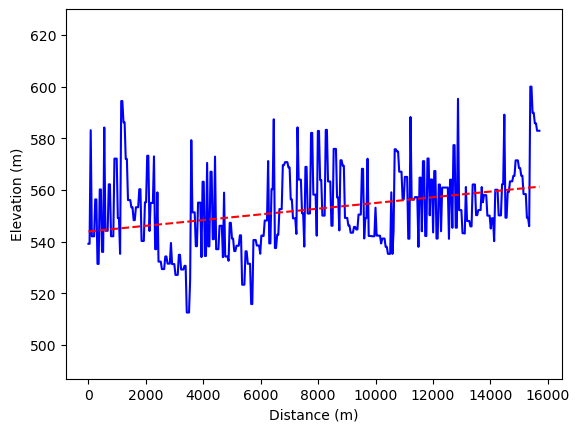

In [217]:
dfRow = dfT[dfT.reach_id == dfT.iloc[10].reach_id]
dfRow = reach

demBufferSize = row.node_mwm*10
DEMRaster = find_dem(dfRow, directory, projection, demBufferSize, False).squeeze()
A, B, C, D = extract_slope_along_raster_line(DEMRaster, dfRow.iloc[0].geometry, True, '', '', add_reg = True, samples = 400)

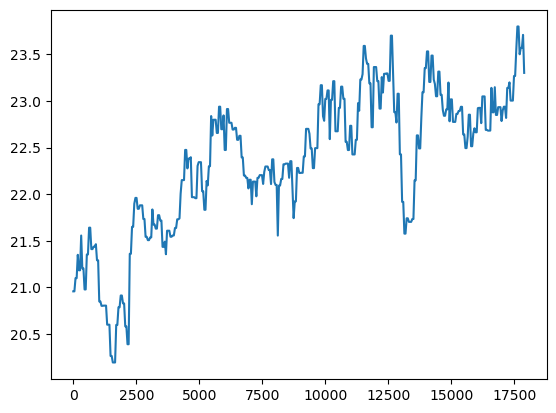

In [177]:
plt.plot(C, D)

In [218]:
print(dfRow[['slope', 'lineSlope']], A)

        slope  lineSlope
263  1.225618   0.007306 0.0011043531126714067


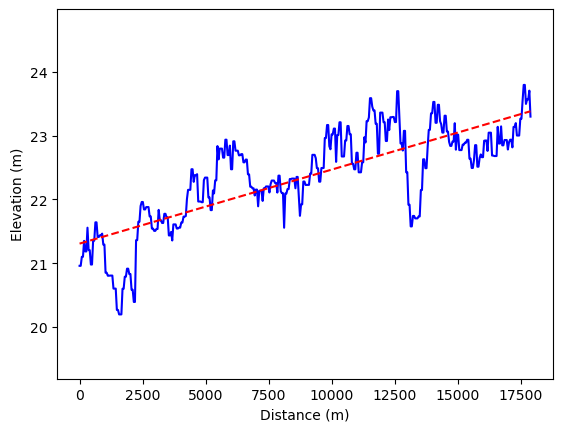

In [202]:
dfSource = gpd.read_file(sourceFiles[0])
dfSource = dfSource.to_crs(projection)

dfSourceRow = dfSource[dfSource.reach_id == dfRow.iloc[0].reach_id]

demBufferSize = row.node_mwm*10
DEMRaster = find_dem(dfRow, directory, projection, demBufferSize, False).squeeze()
A, B, C, D = extract_slope_along_raster_line(DEMRaster, dfRow.iloc[0].geometry, True, '', '', add_reg = True, samples = 400)

In [212]:
d = D.copy()
c = np.array(C.copy())
# d[-10::] = np.nan

missingElev    = np.isnan(d)

c[missingElev] = np.nan
c1 = c[missingElev == False]
d1 = d[missingElev == False]
fit = np.polyfit(c1,d1,1)
fit

array([1.16188205e-04, 2.13072454e+01])

In [203]:
print(dfRow[['slope', 'lineSlope']], A)

       slope  lineSlope
10  0.081231   0.000216 0.00011618820519936357


In [213]:
x = [0,10]
y = [0,5]
sl = np.polyfit(x,y,1)[0]
sl

0.4999999999999999

In [51]:
# def shaped_logarithmic(x,quantL, quantH, FMax, FMin, shape=1.0):
def shaped_logarithmic(x, quantH, FMax, FMin, shape=1.0):
    
    # remove highest values (outliers)
    x[x > x.quantile(quantH)] = x.quantile(quantH)
    # x[x < x.quantile(quantL)] = x.quantile(quantL)
    x = x.values

    xMin, xMax = x.min(), x.max()

    normalized = (np.log(x) - np.log(xMin)) / (np.log(xMax) - np.log(xMin))  # Normalize log(x)
    return FMin + (FMax - FMin) * normalized**shape  # Apply shape transformation

def smooth_factor(df, directory):
    dfInc  = df[df['include_flag'] == '0'].copy()

    dfIncG = dfInc.groupby('combined_reach_id').first()

    dfIncG['smoothFactor'] = shaped_logarithmic(dfIncG['combined_reach_width'],0.95, 1, 5, 1)
    
    dfSM = dfIncG[['smoothFactor', 'combined_reach_width']].reset_index().copy()
    # dfSM.to_csv(directory + 'results/smoothingFactor.csv')
    return dfSM
A = smooth_factor(df, '')

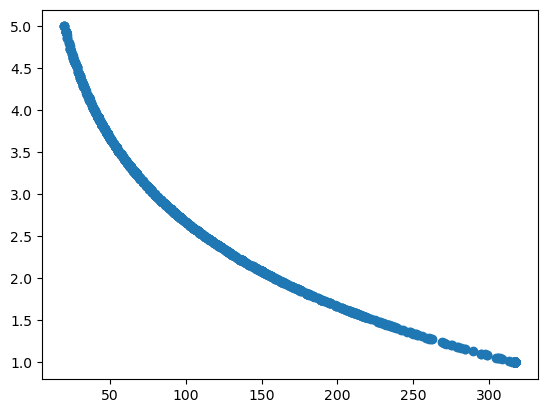

In [52]:
plt.scatter(A['combined_reach_width'], A['smoothFactor'])

(0.0, 200.0)

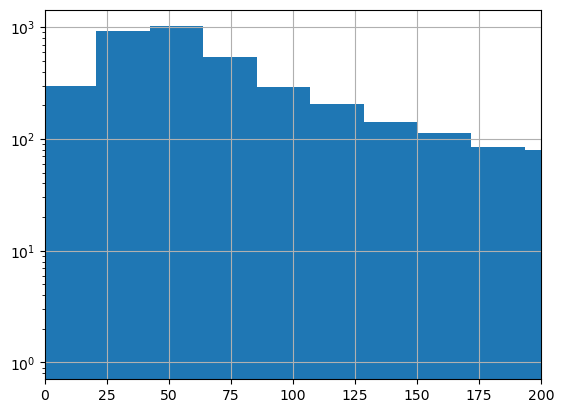

In [17]:
df['combined_reach_width'].hist(bins = 1000)
# plt.xscale('log')
plt.yscale('log')
plt.xlim([0,200])